In [ ]:
Summary :
    
    Training Accuracy : 0.99
    
    Testing Accuracy: 0.99
    
    No. of iteration to converge : 200
    
    Do you think your model overfits? 
    -> No the model does not over fit
    
    
    Features with highest absoulute weight : 
    -> 'dst_host_srv_serror_rate', 'serror_rate', 'dst_host_rerror_rate'
    
    
    Show how the train and test accuracy varies with different regularization strengths. 
    -> Different regularizations and solver combination tried tried using 'penalty = ' and 'solver ='. 
    With the increase in strength , the convergence decreases


In [14]:
import numpy as np
import pandas as pd

features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
'label']

#intrusion_type = ['back','buffer_overflow','ftp_write',
 #'guess_passwd','imap,ipsweep','land,loadmodule',
 #'multihop,neptune','nmap,normal','perl',
 #'phf','pod','portsweep','rootkit',
 #'satan','smurf','spy','teardrop',
 #'warezclient','warezmaster']

In [15]:
data = pd.read_csv('kddcup.data', names = features, header=None)
data.drop(data.loc[data['label']=='normal.'].index, inplace=True)

## Converting the label probe/non probe to 0 and 1

In [16]:
l_nprobe = ['back.','buffer_overflow.','ftp_write.','guess_passwd.','imap.','land.','loadmodule.','multihop.','neptune.','perl.','phf.','pod.','rootkit.','smurf.','spy.','teardrop.','warezclient.','warezmaster.']
l_probe = ['ipsweep.','nmap.','portsweep.','satan.']

#0 if normal , 1 if non-probe , 2 if probe


data['label'] = data['label'].apply(lambda x: 2 if x == 'normal.' else (0 if (x in l_nprobe ) else 1))

# Get unique labels : print(data['label'].unique())
# Review the columns which might need integer encoding data.dtypes

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer



## One Hot Encoding the columns

In [18]:
protocol_end = pd.get_dummies(data.protocol_type)
service_end = pd.get_dummies(data.service)
flag = pd.get_dummies(data.flag)



In [27]:
data_encoded = pd.concat([data,protocol_end,service_end,flag],axis = 'columns')

In [29]:

data_encoded_final = data_encoded.drop(['protocol_type','flag','service'],axis = 'columns')
#data_encoded.drop('service',axis = 'columns')
#data_encoded.drop('flag',axis = 'columns')



le = LabelEncoder()
protocol_end = le.fit_transform(data['protocol_type'])
data.drop('protocol_type',axis = 'columns')
data['protocol_type'] = protocol_end

le1 = LabelEncoder()
service_end = le1.fit_transform(data['service'])
data.drop('service',axis = 'columns')
data['service'] = service_end

le2 = LabelEncoder()
flag_end = le2.fit_transform(data['flag'])
data.drop('flag',axis = 'columns')
data['flag'] = flag_end


# if validation of what all categories were mapped is needed  
#le1.classes_
#le2.classes_


#Quick look at how the data looks
#data.head(10)
#data.dtypes
#data.drop_duplicates(subset=features, keep='first', inplace = True)



#Save the data to a pickle file to avoid reprocessing and enable restartability
#data.to_pickle('data.pkl')

## X and y being created

In [31]:
X = data_encoded_final.drop('label',axis = 'columns')
y =  data_encoded_final.label

# validate if X and y have same rows # y.shape

In [33]:
y.shape


(3925650,)

## Test and Training Split and Scaling the data

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)


sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('Labels count in y:', np.bincount(y))
print('Labels count in y_train:', np.bincount(y_train))

print('Labels count in y_test:', np.bincount(y_test))


Labels count in y: [3884548   41102]
Labels count in y_train: [3107638   32882]
Labels count in y_test: [776910   8220]


## Logistic Regression using Scikit learn

In [40]:
logreg = LogisticRegression(C=1e10, solver='lbfgs', multi_class='ovr',penalty = 'l2' ,max_iter = 1000 , random_state = 1)
logreg.fit(X_train_std, y_train)

#logreg.fit(X_train_std, y_train)

/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Training and Test Error

In [37]:
y_pred = logreg.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 12


In [38]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 1.000


## Number of Iterations to Converge

In [39]:
print(logreg.n_iter_)

[200]


## Plottting the features with highest absoulute weight

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# We create a matrix with all the labels
x_labels_w = X.columns[1:]
Xw = np.array(X[x_labels_w].values)
print(Xw)
print("The matrix dimensions of Xw is " + str(Xw.shape))

[[1.511e+03 2.957e+03 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [1.735e+03 2.766e+03 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.810e+02 1.301e+03 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 ...
 [2.800e+01 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.800e+01 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.800e+01 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]]
The matrix dimensions of Xw is (3925650, 117)


In [42]:
# For plotting in the Jupyter Notebook environment as an inline output
%matplotlib inline

/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


<StemContainer object of 3 artists>

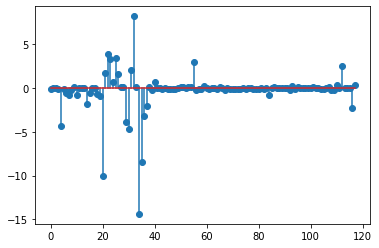

In [43]:
# By default, LogisticRegression() is set on penalty as L2 and C=1.
# To simulate no regularization, we will select a large C to minimize regularization to later 
# show the effect of regularization

#logreg_w=LogisticRegression(C=1e10,solver = 'lbfgs')

#logreg_w.fit(Xw,y)

W=logreg.coef_

W=W.flatten()
plt.stem(W)

In [44]:
idx1=np.argsort(np.abs(W))[-1]
idx2=np.argsort(np.abs(W))[-2]
idx3=np.argsort(np.abs(W))[-3]

heavy=[x_labels_w[idx1], x_labels_w[idx2],x_labels_w[idx3]]
heavy

['dst_host_srv_serror_rate', 'serror_rate', 'dst_host_rerror_rate']